In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',None)
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder

In [3]:
def change_time(num):
  if int(num)>=8 and int(num)<12:
    return 0
  elif int(num)>=12 and int(num)<17:
    return 1
  elif int(num)>=17 and int(num)<=23:
    return 2
  elif int(num)>=0 and int(num)<5:
    return 3
  else:
    return 4
accident_data = pd.read_parquet("./drive/MyDrive/accident_data.parquet")
accident_data = accident_data.drop(["Date"],axis=1)
accident_data = accident_data.dropna(axis=0,subset=["Time"])
accident_data["Time"] = accident_data["Time"].apply(lambda x:change_time(str(x)[:2]))

In [4]:
#Special conditions at site 15?
#Unclassified->nan
#None->nan
#Data Missing or out of range->nan
def missing_values_change(val):
    if str(val)=="Unclassified" or str(val)=='None' or str(val)=="Data missing or out of range" or str(val)=="Unallocated":
      return np.nan
    else:
      return val
for col in accident_data.columns:
  accident_data[col] = accident_data[col].apply(lambda x:missing_values_change(x))

In [5]:
#What percentage are missing values
ncounts = pd.DataFrame([accident_data.isna().mean()]).T
ncounts.columns=["percentage_missing"]

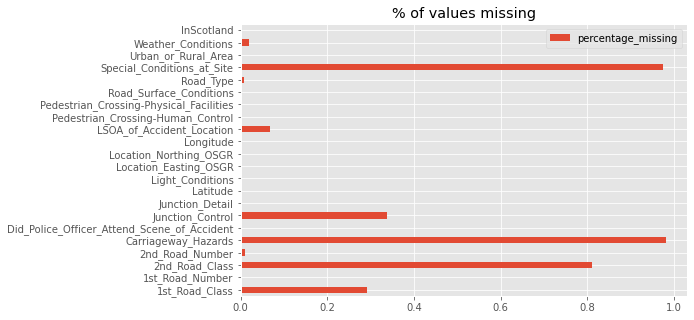

In [6]:
ncounts.query("percentage_missing>0").plot(kind="barh",figsize=(8,5),title='% of values missing')

In [7]:
cols_to_fill = list(ncounts.query("percentage_missing>0.01").index)  #Number of features where more than 1% of values are missing

In [8]:
subset = [col for col in accident_data.columns if col not in cols_to_fill]
accident_data = accident_data.dropna(axis=0,subset=subset)

In [9]:
accident_data_missing_tag_df = accident_data[cols_to_fill].isna()
accident_data_missing_tag_df.columns = [f"{c}_missing" for c in accident_data_missing_tag_df.columns]

In [10]:
accident_data = pd.concat([accident_data,accident_data_missing_tag_df],axis=1)

In [11]:
num_cols = [col for col in accident_data.columns if accident_data[col].dtype=="float64" or accident_data[col].dtype=="int64"]
cat_cols = [col for col in accident_data.columns if col not in num_cols and (col!="Accident_Index") and col!="Accident_Severity"]

In [12]:
le = LabelEncoder()
for col in cat_cols:
  accident_data[col] = le.fit_transform(accident_data[col])

In [13]:
X = accident_data.drop(["Accident_Severity"],axis=1)
y = accident_data.Accident_Severity
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
!rm -r kuma_utils
!git clone https://github.com/analokmaus/kuma_utils.git

rm: cannot remove 'kuma_utils': No such file or directory
Cloning into 'kuma_utils'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 915 (delta 104), reused 102 (delta 96), pack-reused 795
Receiving objects: 100% (915/915), 679.99 KiB | 18.89 MiB/s, done.
Resolving deltas: 100% (592/592), done.


In [15]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [16]:
cat_cols = [f for f in cols_to_fill if f!="2nd_Road_Number"]

In [ ]:
cat_cols

['1st_Road_Class',
 '2nd_Road_Class',
 'Carriageway_Hazards',
 'Junction_Control',
 'LSOA_of_Accident_Location',
 'Special_Conditions_at_Site',
 'Weather_Conditions']

In [17]:
lgb_imptr = LGBMImputer(n_iter=100,verbose=True,cat_features=cat_cols)
features = [f for f in cols_to_fill]
X_train_imputed = lgb_imptr.fit_transform(X_train[features])
X_valid_imputed = lgb_imptr.transform(X_valid[features])


X_train_imputed = pd.DataFrame(X_train_imputed,columns=features)
X_valid_imputed = pd.DataFrame(X_valid_imputed,columns=features)

X_train_imputed.index = X_train.index
X_valid_imputed.index = X_valid.index

X_train_final = pd.concat([X_train.drop(cols_to_fill,axis=1),X_train_imputed],axis=1)
X_valid_final = pd.concat([X_valid.drop(cols_to_fill,axis=1),X_valid_imputed],axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

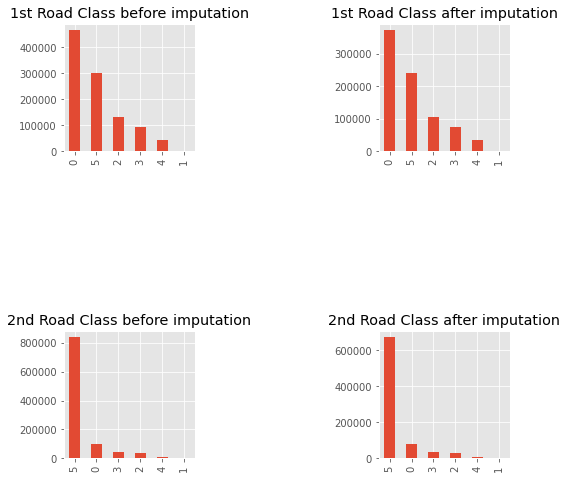

In [19]:
plt.subplot(3,3,1)
accident_data["1st_Road_Class"].value_counts().plot(kind="bar",title="1st Road Class before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["1st_Road_Class"].value_counts().plot(kind="bar",title="1st Road Class after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["2nd_Road_Class"].value_counts().plot(kind="bar",title="2nd Road Class before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["2nd_Road_Class"].value_counts().plot(kind="bar",title="2nd Road Class after imputation",figsize=(8,8))

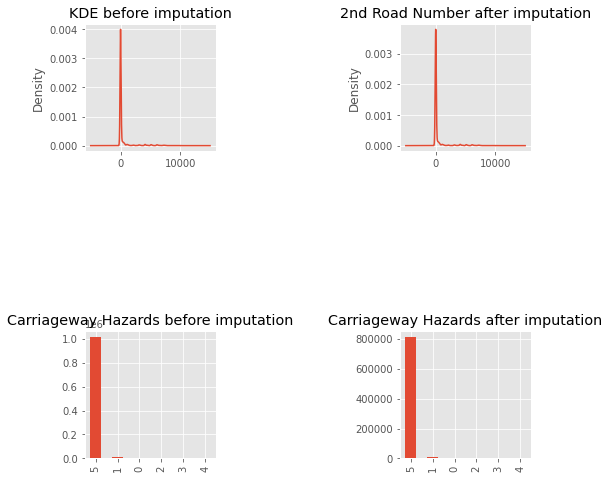

In [20]:
plt.subplot(3,3,1)
accident_data["2nd_Road_Number"].plot(kind="kde",title="KDE before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["2nd_Road_Number"].plot(kind="kde",title="2nd Road Number after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["Carriageway_Hazards"].value_counts().plot(kind="bar",title="Carriageway Hazards before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["Carriageway_Hazards"].value_counts().plot(kind="bar",title="Carriageway Hazards after imputation",figsize=(8,8))

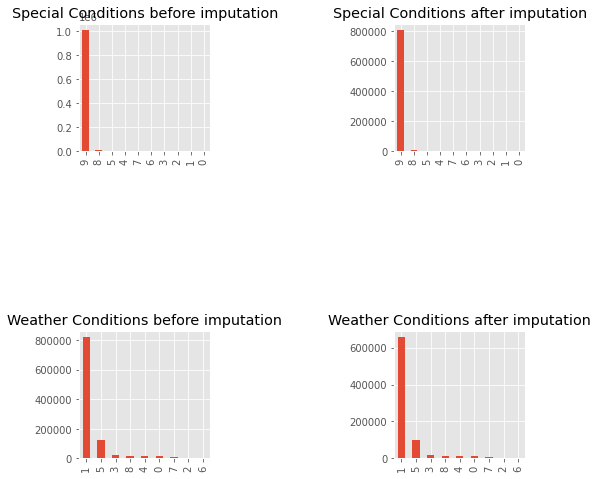

In [21]:
plt.subplot(3,3,1)
accident_data["Special_Conditions_at_Site"].value_counts().plot(kind="bar",title="Special Conditions before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["Special_Conditions_at_Site"].value_counts().plot(kind="bar",title="Special Conditions after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["Weather_Conditions"].value_counts().plot(kind="bar",title="Weather Conditions before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["Weather_Conditions"].value_counts().plot(kind="bar",title="Weather Conditions after imputation",figsize=(8,8))

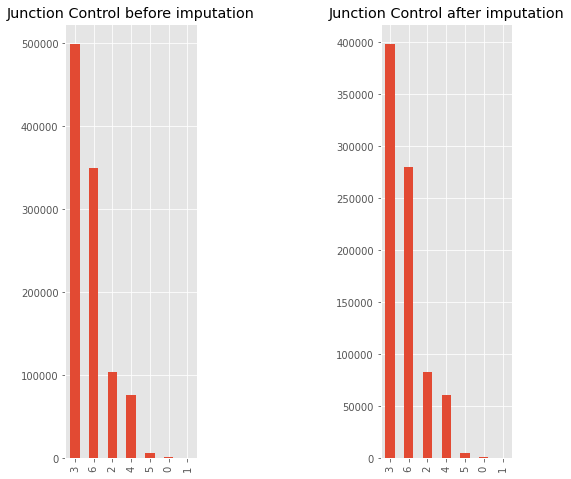

In [22]:
plt.subplot(1,3,1)
accident_data["Junction_Control"].value_counts().plot(kind="bar",title="Junction Control before imputation",figsize=(8,8))
plt.subplot(1,3,3)
X_train_final["Junction_Control"].value_counts().plot(kind="bar",title="Junction Control after imputation",figsize=(8,8))
